See for examples https://github.com/cduck/drawSvg

Great series on SVG coordinates https://www.sarasoueidan.com/blog/svg-coordinate-systems/

In [3]:
import drawSvg as draw
import numpy as np

In [3]:
d = draw.Drawing(200, 100, origin='center', displayInline=False)

# Draw an irregular polygon
d.append(draw.Lines(-80, -45,
                    70, -49,
                    95, 49,
                    -90, 40,
                    close=False,
            fill='#eeee00',
            stroke='black'))

# Draw a rectangle
r = draw.Rectangle(-80,0,40,50, fill='#1248ff')
r.appendTitle("Our first rectangle")  # Add a tooltip
d.append(r)

# Draw a circle
d.append(draw.Circle(-40, -10, 30,
            fill='red', stroke_width=2, stroke='black'))

# Draw an arbitrary path (a triangle in this case)
p = draw.Path(stroke_width=2, stroke='lime',
              fill='black', fill_opacity=0.2)
p.M(-10, 20)  # Start path at point (-10, 20)
p.C(30, -10, 30, 50, 70, 20)  # Draw a curve to (70, 20)
d.append(p)

# Draw text
d.append(draw.Text('Basic text', 8, -10, 35, fill='blue'))  # Text with font size 8
d.append(draw.Text('Path text', 8, path=p, text_anchor='start', valign='middle'))
d.append(draw.Text(['Multi-line', 'text'], 8, path=p, text_anchor='end'))

# Draw multiple circular arcs
d.append(draw.ArcLine(60,-20,20,60,270,
            stroke='red', stroke_width=5, fill='red', fill_opacity=0.2))
d.append(draw.Arc(60,-20,20,60,270,cw=False,
            stroke='green', stroke_width=3, fill='none'))
d.append(draw.Arc(60,-20,20,270,60,cw=True,
            stroke='blue', stroke_width=1, fill='black', fill_opacity=0.3))

# Draw arrows
arrow = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient='auto')
arrow.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='red', close=True))
p = draw.Path(stroke='red', stroke_width=2, fill='none',
              marker_end=arrow)  # Add an arrow to the end of a path
p.M(20, -40).L(20, -27).L(0, -20)  # Chain multiple path operations
d.append(p)
d.append(draw.Line(30, -20, 0, -10,
            stroke='red', stroke_width=2, fill='none',
            marker_end=arrow))  # Add an arrow to the end of a line

d.setPixelScale(2)  # Set number of pixels per geometry unit
#d.setRenderSize(400,200)  # Alternative to setPixelScale
# d.saveSvg('example.svg')
# d.savePng('example.png')

# Display in Jupyter notebook
d.rasterize()  # Display as PNG
d  # Display as SVG

In [14]:
W = 800
H = 600
ITS = [0, 2, 5, 12]  # illumina distance thresholds
NTS = [0, 3, 5, 11]  # nanopore distance thresholds
L = len(ITS)

In [237]:
# note the origin here is actually the bottom left, not top left
canvas = draw.Drawing(width=W, height=H, origin=(0, 0), displayInline=False)

for y in np.arange(H/L, H, H/L):
    start = (0, y)
    end = (W, y)
    canvas.append(draw.Line(*start, *end, stroke="black", stroke_dasharray="5 5 4"))
    
for i, t in enumerate(ITS, start=1):
    x = 0
    y = H - (((H/L)*i - (H/L/2)))
    txt = draw.Text(f"{t}", fontSize=12, x=x, y=y)
    canvas.append(txt)

canvas

In [17]:
help(draw.Text)

Help on class Text in module drawSvg.elements:

class Text(DrawingParentElement)
 |  Text(text, *args, path=None, id=None, _skipCheck=False, **kwargs)
 |  
 |  Text
 |  
 |  Additional keyword arguments are output as additional arguments to the
 |  SVG node e.g. fill='red', font_size=20, text_anchor='middle',
 |  letter_spacing=1.5.
 |  
 |  CairoSVG bug with letter spacing text on a path: The first two letters
 |  are always spaced as if letter_spacing=1.
 |  
 |  Method resolution order:
 |      Text
 |      DrawingParentElement
 |      DrawingBasicElement
 |      DrawingElement
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, text, fontSize, x=None, y=None, *, center=False, valign=None, lineHeight=1, lineOffset=0, path=None, startOffset=None, pathArgs=None, tspanArgs=None, cairoFix=True, _skipCheck=False, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  appendLine(self, line, **kwargs)
 |  
 |  writeChildrenConte

In [18]:
help(enumerate)

Help on class enumerate in module builtins:

class enumerate(object)
 |  enumerate(iterable, start=0)
 |  
 |  Return an enumerate object.
 |  
 |    iterable
 |      an object supporting iteration
 |  
 |  The enumerate object yields pairs containing a count (from start, which
 |  defaults to zero) and a value yielded by the iterable argument.
 |  
 |  enumerate is useful for obtaining an indexed list:
 |      (0, seq[0]), (1, seq[1]), (2, seq[2]), ...
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



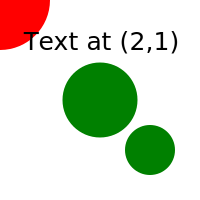

In [72]:
d = draw.Drawing(4,4, origin=(0,0))

g = draw.Group(transform='scale(1,-1) translate(0,4)')
g.append(draw.Circle(0,0,1, fill='red'))
g.append(draw.Circle(2,2,0.75, fill='green'))
g.append(draw.Circle(3,3,0.5, fill='green'))
g.append(draw.Text('Text at (2,1)',0.5, 0,0, text_anchor='middle',
                   transform='scale(1,-1) translate(2,1)'))
d.append(g)

d.setRenderSize(h=200)
d